In [1]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.family'] = 'IPAPGothic'
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
import datetime
from statistics import mean
from statistics import median
import calendar
import datetime

In [2]:
# OANDA API v20の口座IDとAPIトークン
accountID = "101-009-12609641-001"
access_token = "11f2a77cf99d3d29afc4c1cb1a0fb36b-e0fc1d1bf476926157f1d5992466fdf4"
# OANDAのデモ口座へのAPI接続
api = API(access_token=access_token, environment="practice")

In [3]:
# APIから取得したレートをPandasのDataFrameへ
def to_dataframe(r):
    data = []
    for raw in r.response['candles']:
        data.append([raw['time'], raw['volume'], raw['mid']['o'], raw['mid']['h'], raw['mid']['l'], raw['mid']['c']])

    # リストからPandas DataFrameへ変換
    df = pd.DataFrame(data)
    df.columns = ['Time', 'Volume', 'Open', 'High', 'Low', 'Close']
    df['Time'] = pd.to_datetime(df['Time'])
    for col in ['Open', 'High', 'Low', 'Close']:
        df[col] = df[col].apply(float)
    return df

In [4]:
# 第何何曜日（第nX曜日）の日付を返す関数
def get_day_of_nth_dow(year, month, nth, dow):
    '''dow: Monday(0) - Sunday(6)'''
    if nth < 1 or dow < 0 or dow > 6:
        return None

    first_dow, n = calendar.monthrange(year, month)
    day = 7 * (nth - 1) + (dow - first_dow) % 7 + 1

    return day if day <= n else None

In [5]:
def get_data(count, gran, year, month, day, hour, minute, second):
    fmt = '%Y-%m-%dT%H:%M:00.000000Z'
    _from = datetime.datetime(year=year, month=month, day=day,
                              hour=hour, minute=minute, second=second).strftime(fmt)
    params = {
        "count": count,
        "granularity": gran,
        'from': _from,
#         'dailyAlignment': 0
    }
    r = instruments.InstrumentsCandles(instrument="USD_JPY", params=params)
    api.request(r)
    df = to_dataframe(r)
    return df

In [7]:
def get_data_super(start, end, gran):
    # OANDA API v20の口座IDとAPIトークン
    accountID = "101-009-12789646-001"
    access_token = "1ab53171ce4413f408de6da28ea23089-6426c3d3cc947dba212b3766d1be45c6"
    # OANDAのデモ口座へのAPI接続
    api = API(access_token=access_token, environment="practice")
    # xxxx-xx-xx～xxxx-xx-xx の期間のデータを取得してデータフレームを返す
    s_year, s_month, s_day, s_hour, s_minute, s_second = map(int, start.split('-'))
    e_year, e_month, e_day, e_hour, e_minute, e_second = map(int, end.split('-'))
    fmt = '%Y-%m-%dT%H:%M:00.000000Z'
    from_ = datetime.datetime(year=s_year, month=s_month, day=s_day,
                              hour=s_hour, minute=s_minute, second=s_second).strftime(fmt)
    to_ = datetime.datetime(year=e_year, month=e_month, day=e_day,
                            hour=e_hour, minute=e_minute, second=e_second).strftime(fmt)
    to_dt = '{}-{}-{} {}:{}:{}'.format(e_year, e_month, e_day, e_hour, e_minute, e_second)
    to_unix = datetime.datetime.strptime(to_dt, '%Y-%m-%d %H:%M:%S').timestamp()
    df = pd.DataFrame()
    # 5000個制限に引っかからなければこっちの処理
    try:
        params = {
            "granularity": gran,
            'from': from_,
            'to': to_
        }
        r = instruments.InstrumentsCandles(instrument="USD_JPY", params=params)
        api.request(r)
        df = to_dataframe(r)
    # 引っかかればこっちの処理
    except:
        i = True
        while i:
            df_tmp = get_data(count=5000, gran=gran, year=s_year, month=s_month, day=s_day,
                             hour=s_hour, minute=s_minute, second=s_second)
            # ケツが同じなら止める (最新迄用)
            if df.tail(1).reset_index(drop=True).equals(df_tmp.tail(1).reset_index(drop=True)):
                i = False
            else:
                df = pd.concat([df, df_tmp], ignore_index=True)
                index = df_tmp.tail(1).index[0]
                s_year = df_tmp.iat[index, 0].year
                s_month = df_tmp.iat[index, 0].month
                s_day = df_tmp.iat[index, 0].day
                s_hour = df_tmp.iat[index, 0].hour
                s_minute = df_tmp.iat[index, 0].minute
                s_second = df_tmp.iat[index, 0].second
                # print('{}-{}-{}-{}-{}-{}'.format(s_year, s_month, s_day, s_hour, s_minute, s_second))
                # 5000個ずつ取得してエンドの unix 超えたら止める
                if to_unix < df.iat[df.tail(1).index[0], 0].timestamp():
                    # はみ出した分をここで切り落とす
                    for i in range(len(df.index) - 5000, len(df.index)):
                        if to_unix <= df.iat[i, 0].timestamp():
                            df = df[:i]
                            break
                    i = False
    return df

In [66]:
# バックテスト
def back_test(df, K, m, start='', end='', gran='M5'):
    range_ = 0
    range_list = []
    ave_range = 0
    least_5 = 0
    pos = 'None'
    profit_list = []
    entry_rate = 0
    pos_count = 0
    fee = 0.002
    tmp_i = 0
    
    if isinstance(df, pd.DataFrame):
        pass
    else:
        df = get_data_super(start, end, gran)
    
    pos_df = pd.DataFrame(columns=['date', 'entry_rate', 'exit_rate', 'profit'])
    
    # OANDA API v20の口座IDとAPIトークン
    accountID = "101-009-12609641-001"
    access_token = "11f2a77cf99d3d29afc4c1cb1a0fb36b-e0fc1d1bf476926157f1d5992466fdf4"
    # OANDAのデモ口座へのAPI接続
    api = API(access_token=access_token, environment="practice")

    # 実行
    for i in range(len(df.index) - (1+m)):
        next_rate = df.iat[i+1, 2] # シグナル点灯した次の足の始値(entry)
        exit_rate = df.iat[i+m, 5] # m本後の終値
        # 上ひげ
        if df.iat[i, 2] >= df.iat[i, 5]: # Open >= Close
            range_ = round(df.iat[i, 2] - df.iat[i, 5], 3) # Open - Close
            up_hige = round(df.iat[i, 3] - df.iat[i, 2], 3) # High - Open
            down_hige = round(df.iat[i, 5] - df.iat[i, 4], 3) # Close - Low
        elif df.iat[i, 2] < df.iat[i, 5]: # Open < Close
            range_ = round(df.iat[i, 5] - df.iat[i, 2], 3) # Close - Open
            up_hige = round(df.iat[i, 3] - df.iat[i, 5], 3) # High - Close
            down_hige = round(df.iat[i, 2] - df.iat[i, 4], 3) # Open - Low
    
        # 上昇トレンドと判断しロング
        if down_hige > range_ * K:
            if pos == 'None':
                pos_count+=1
                entry_rate = next_rate
                profit = entry_rate - exit_rate - fee
                profit_list.append(profit)
                tmp_se = pd.Series( [df.iat[i,0], entry_rate, exit_rate, profit ], index=pos_df.columns )
                pos_df = pos_df.append( tmp_se, ignore_index=True )
                pos = 'entry_long'
                tmp_i = i
        # 下降トレンドと判断しショート
        if up_hige > range_ * K:
            if pos == 'None':
                pos_count+=1
                entry_rate = next_rate
                profit = exit_rate - entry_rate - fee
                profit_list.append(profit)
                tmp_se = pd.Series( [df.iat[i,0], entry_rate, exit_rate, profit ], index=pos_df.columns )
                pos_df = pos_df.append( tmp_se, ignore_index=True )
                pos = 'entry_short'
                tmp_i = i
        # ポジションのリセット
        if tmp_i + m == i:
            pos = 'None'
        
    pos_df = pos_df.drop_duplicates(keep=False, subset='date').reset_index(drop=True)
    print('pos count: {:>5}, profit: {:>6.3f}'.format(pos_df.shape[0], pos_df['profit'].sum()))
    return pos_df, df

In [77]:
df = get_data_super('2010-01-01-00-00-00', '2019-01-01-00-00-00', 'M5')

In [87]:
pos_df, df = back_test(df, K=20, m=20)

pos count: 15101, profit: -43.567


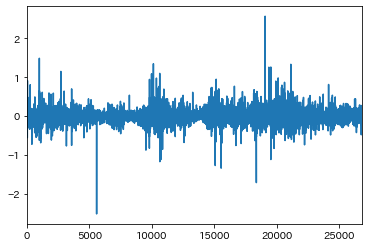

In [80]:
pos_df['profit'].plot()

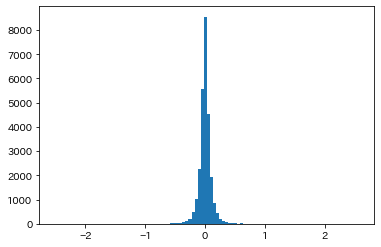

In [81]:
plt.hist(pos_df['profit'], bins=100)
plt.show()

In [82]:
pos_df[pos_df['profit']>0].shape[0]

12754

In [83]:
pos_df[pos_df['profit']<=0].shape[0]

14055

In [84]:
pos_df[pos_df['profit']>0]['profit'].sum()

892.478000000001

In [85]:
pos_df[pos_df['profit']<=0]['profit'].sum()

-961.8630000000018

In [86]:
pos_df

,date,entry_rate,exit_rate,profit
0,2010-01-03 18:45:00+00:00,92.935,92.935,-0.002
1,2010-01-03 23:20:00+00:00,92.818,92.870,-0.054
2,2010-01-04 00:45:00+00:00,92.938,92.995,-0.059
3,2010-01-04 04:15:00+00:00,92.766,92.743,-0.025
4,2010-01-04 05:40:00+00:00,92.827,92.924,-0.099
5,2010-01-04 07:45:00+00:00,93.154,92.860,0.292
6,2010-01-04 10:40:00+00:00,92.848,92.792,0.054
7,2010-01-04 12:40:00+00:00,92.899,92.806,0.091
8,2010-01-04 13:55:00+00:00,92.641,92.676,-0.037
9,2010-01-04 16:05:00+00:00,92.366,92.558,0.190
